# Text Analysis 

# Part 1: Data Cleaning
Feature Engineering + Text Cleaning. Outputs three datasets

In [6]:
%pip install spacy
%pip install pdtext
%pip install readability

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Created wheel for readability: filename=readability-0.3.1-py3-none-any.whl size=35460 sha256=8be0698293419489b048f6b9f09ebce074878ccc256ba0503ac88cabede9b0fe
  Stored in directory: /Users/violadarmawan/Library/Caches/pip/wheels/4e/7c/09/fd4dab2933175bd6e6f0fe30f2f1abf3be749c6f68b8c0fa46
Successfully built readability
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Step 1: Setup
# import libraries
import pandas as pd
import numpy as np
import string
import spacy.cli
import matplotlib.pyplot as plt
import pdtext
import readability
from pdtext.tf import word_count
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/violadarmawan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
# Step 2: Load dataset
try:
    df = pd.read_csv('df_final.csv')
except:
    import zipfile
    with zipfile.ZipFile('df_final.zip', 'r') as zip_ref:
        zip_ref.extractall('')
    df = pd.read_csv('df_final.csv')

In [10]:
# Step 3: Remove missing text and clean text for LDA
# much of the text is missing; thus, we keep only the data with text
missing = (df["text"].isnull()) | ((df["text"] == '[deleted]')) | ((df["text"] == '[removed]'))
df = df.loc[~missing]

##############################
# clean the text in df for LDA
##############################
# stemming
eng_stemmer = SnowballStemmer("english")

def stem_sentence(sentence):
    new_sentence = ''
    for word in word_tokenize(sentence):
        new_sentence = new_sentence + ' ' + eng_stemmer.stem(word)
    return new_sentence.strip()

def clean_text(s, stem = True):
    # lowercase
    s = s.lower()
    # remove numbers: https://stackoverflow.com/questions/12851791/removing-numbers-from-string
    s = ''.join([i for i in s if not i.isdigit()])
    # remove punctuation:
    s = s.translate(str.maketrans('', '', string.punctuation))
    # stem
    if stem:
        s = stem_sentence(s)
    return(s)

# get clean text from which to extract topics
clean_text_df = df['text'].apply(clean_text)

clean_text_df = pd.DataFrame(clean_text_df, index=df.index)

In [11]:
# Quick check
clean_text_df.shape[0] == df.shape[0]

In [14]:
# Step 4: Export clean_text_df to csv
#clean_text_df.to_csv('nlp_data/clean_text_df.csv', index=True)

# In case analysis has been done already: 
clean_text_df = pd.read_csv('nlp_data/clean_text_df.csv', index_col=0)

In [15]:
clean_text_df

,text
3,i rememb mine in but quit becaus it was onli b...
6,pool control of the hashrat a hand control the...
8,what do the peopl think is go to happen when c...
11,with all the talk that increas blocksiz would ...
21,status of the bitcoin network as of friday jan...
...,...
574609,that what my friend say i wasnt sure how to re...
574614,may all your wallet quadrupl in valu
574616,the emot decis would have been buy more it mig...
574617,it harder than peopl on twitter make it out to...


In [19]:
# Step 5: Sentiment
# For background/more info, check out: 
# https://github.com/cjhutto/vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
fn_analyzer = lambda x: analyzer.polarity_scores(x)['compound']

# # example for paper
# analyzer.polarity_scores(example_text)['compound'] # 0.7579

# warning --slow
sentiment = df['text'].apply(fn_analyzer)

sentiment.head()

# export sentiment
sentiment.to_csv('nlp_data/sentiment.csv', index=True)

# Or, in case analysis is already conducted: 
sentiment = pd.read_csv('nlp_data/sentiment.csv', index_col = 0)

In [22]:
# Step 6: Feature Engineering
# features we can get from the readability package
features = ['dale_chall', 'characters_per_word', 'syll_per_word', 'words_per_sentence', 'sentences_per_paragraph',
            'type_token_ratio', 'characters', 'syllables',
            'words', 'wordtypes', 'sentences', 'paragraphs',
            'long_words', 'complex_words', 'complex_words_dc',
            'tobeverb', 'auxverb', 'conjunction', 'pronoun',
            'preposition', 'nominalization']

# initiate empty features dataframe
feature_df = pd.DataFrame(np.nan, index = range(len(df)),
                          columns=features)

# function that outputs a row of features
def get_features(text, idx):
    results = readability.getmeasures(text, lang='en')
    DaleChall = pd.DataFrame(results['readability grades']['DaleChallIndex'],
                             columns = ['dale_chall'],
                             index = [idx])
    sentence_df = pd.DataFrame(results['sentence info'],
                               columns = results['sentence info'].keys(),
                               index = [idx])
    word_df = pd.DataFrame(results['word usage'],
                               columns = results['word usage'].keys(),
                               index = [idx])
    op = pd.concat([DaleChall, sentence_df, word_df], axis=1)
    return(op)

# # example
# get_features(example_text, idx=0)

# fills the feature dataframe warning --slow
for i in range(len(df)):
    try:
        op = get_features(df['text'].iloc[i], idx=i)
    except:
        op = pd.DataFrame(np.nan, index = [i],columns=features)
    feature_df.append(op)

# add the index and id
# we need this to join the dataframes later on

feature_df.index = df.index
feature_df['id'] = df['id']

# export feature_df as csv
feature_df.to_csv('nlp_data/feature_df.csv', index=True)

# Or, if analysis is already done:
feature_df = pd.read_csv('nlp_data/feature_df.csv', index_col=0)

# Part 2: LDA

In [25]:
# Step 1: Read in file
df = pd.read_csv('nlp_data/clean_text_df.csv', index_col = 0)

# after cleaning some text is nan - was originally emojis perhaps
missing = (df["text"].isnull()) | ((df["text"] == '[deleted]')) | ((df["text"] == '[removed]'))
df = df.loc[~missing]


In [27]:
# Step 2: Define stop words, and tokenize/vectorize
# stop words: english + bitcoin related + things we have found after cleaning
my_stop_words = text.ENGLISH_STOP_WORDS.union(["https", "www", "com", "bitcoin", "btc", "bitcoins",
                                              "just","like", "wallet", "btc", "blockchain",
                                               "crypto", "coinbase", "amp",
                                               "im", "iv", "id", "ive", "ampxb"])

# example for paper
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

text_tokens = word_tokenize('your a grand old flag your a highfli flag and forev in peac may you wave')
tokens_without_sw = [word for word in text_tokens if not word in my_stop_words]
print(tokens_without_sw)

# get the most common words
vectorizer = CountVectorizer(lowercase=True,
                             max_df = 0.3,
                             stop_words=my_stop_words,
                             min_df=0.025)

# fit the CountVectorizer to the clean text
vectorizer.fit(df['text'])

# get the vocabulary of the text
vocab = vectorizer.get_feature_names()
len(vocab) # 241
# save this for 02-lda-topics.py
dump(vocab,'vocab.joblib')

# term frequency
tf = vectorizer.transform(df['text'])

['grand', 'old', 'flag', 'highfli', 'flag', 'forev', 'peac', 'wave']


In [29]:
# Step 3: Compute LDA Models
for cp in [3, 5, 8, 10, 15, 20]:
    # LDA topic model
    lda_model = LatentDirichletAllocation(n_components=cp,
                                          max_iter=10,
                                          evaluate_every=1,
                                          random_state=420,
                                          verbose=1)
    # fit
    lda_model.fit_transform(tf)

    # Log Likelihood: Higher the better
    #print("Log Likelihood: ", lda_model.score(tf))
    # Log Likelihood:  -26461197.1741212

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    #print("Perplexity: ", lda_model.perplexity(tf))
    # Perplexity:  396.69211197749775

    fname = 'lda-models/2021-13-mai-lda-model-stemmed-ncomp-' + str(cp) + '.joblib'
    dump(lda_model,fname)

In [30]:
# Step 4: Perplexity of LDA Models
# we know that perplexity decreases with the number of topics
# thus we use a rule-of-thumb for unsupervised learning: "elbow rule"

lst_perplexity = []
lst_loglik = []


# warning -- slow
for cp in [3, 5, 8, 10, 15, 20]:
    fname = '2021-13-mai-lda-model-stemmed-ncomp-' + str(cp) + '.joblib'
    lda_model = load(fname)
    lst_loglik.append(lda_model.score(tf))
    lst_perplexity.append(lda_model.perplexity(tf))
    print(lst_perplexity)

In [31]:
# Step 5: Plot Number of components vs. perplexity
%matplotlib inline

plt.plot([3, 5, 8, 10, 15, 20],
         lst_perplexity,
         'r-o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('LDA Model Perplexity by Number of Topics')
#plt.show()
plt.savefig('plots/2021-13-mai-perplexity-plot.png')

In [32]:
# plot the number of compotents vs. perplexity, exclude 20
plt.plot([3, 5, 8, 10, 15],
         lst_perplexity[0:len(lst_perplexity)-1],
         'r-o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('LDA Model Perplexity by Number of Topics')
#plt.show()
plt.savefig('plots/2021-13-mai-perplexity-plot-3to15.png')

In [33]:
# Step 6: Plot Number of components vs log-likelihood
plt.plot([3, 5, 8, 10, 15, 20],
         lst_loglik,
         'b-o')
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.title('LDA Model Log Likelihood by Number of Topics')
# plt.show()
plt.savefig('plots/2021-13-mai-loglik-plot.png')

In [34]:
# plot the number of components vs log-likelihood
plt.plot([3, 5, 8, 10, 15],
         lst_loglik[0:len(lst_loglik)-1],
         'b-o')
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.title('LDA Model Log Likelihood by Number of Topics')
#plt.show()
plt.savefig('plots/2021-13-mai-loglik-plot-3to15.png')

Select final LDA model

The "elbow" is at 10 components. However, we can further reduce dimensionality
with 5 components, and we find an interpretable output.
To make a final decision, we will assess the performance of the topic scores
on predictive models.


In [35]:
# Step 7: Output Dataset with LDA scores
for cp in [5, 10]:
    fname = 'lda-models/2021-13-mai-lda-model-stemmed-ncomp-' + str(cp) + '.joblib'
    lda_model = load(fname)

    thread_topics = lda_model.transform(tf)
    # thread_topics.shape # (177277, 10) good

    topic_df = pd.DataFrame(thread_topics)

    new_cols = pd.Series(range(cp)).apply(lambda x: 'topic_'+str(x)).tolist()
    topic_df.columns = new_cols
    # rename the index to be like the original df
    topic_df.index = df.index

    # concatenate
    #df_with_topics = pd.concat([df, topic_df], axis = 1)
    #print(df_with_topics.shape) # (177277, 24)

    # write as csv
    op_fname = 'nlp_data/2021-15-mai-df_topics_' + str(cp) + '.csv'
    print(op_fname)
    topic_df.to_csv(op_fname, index=True)

# Part 3: LDA Topics

In [36]:
# Step 1: Import libraries
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/violadarmawan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


For more information, c.f.:
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [37]:
# Step 2: Plot the top Words and save file
def plot_top_words(model, feature_names, n_top_words, title, fig_fname):
    fig, axes = plt.subplots(1, 5, figsize=(30, 12), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.5)
    #plt.savefig('plots/2021-13-mai-topics-in-lda-5-cp.png')
    plt.savefig(fig_fname)
    #plt.show()

In [38]:
# load the vocabulary we got from 01-thread-info.py
vocab = load('vocab.joblib')

In [39]:
# Step 3: Plot for LDA model with 5 and 10 topics
# plot for LDA model with 5 and 10 topics
for cp in [5,10]:
    # load the LDA model
    fname = 'lda-models/2021-13-mai-lda-model-stemmed-ncomp-' + str(cp) + '.joblib'
    lda_model = load(fname)

    plot_top_words(lda_model,
                   feature_names=vocab,
                   n_top_words=10,
                   title = 'Topics in LDA model',
                   fig_fname= 'plots/2021-13-mai-topics-in-lda-' + str(cp) +'-cp.png')


# Part 4: t-SNE representation

In [45]:
# Step 1: Install necessary modules
# Requires Firefox
%pip install geckodriver-autoinstaller
%pip install selenium
from selenium import webdriver
import geckodriver_autoinstaller
geckodriver_autoinstaller.install();

# Source: https://pypi.org/project/geckodriver-autoinstaller/

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [46]:
# Step 2: Import necessary modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
import matplotlib.colors as mcolors
from bokeh.models import Label
from bokeh.io import export_png

In [49]:
# Step 3: Perform the t-SNE
# Stochastic procedure, so results will change every time the analysis is run. 
def tSNE_plot(n_topic):
    input_fname = 'nlp_data/df_topics_' + str(n_topic) + '.csv'
    tsne_df = pd.read_csv(input_fname, index_col = 0)
    
    keep = pd.Series(range(n_topic)).apply(lambda x: 'topic_'+str(x)).tolist()
    tsne_df = tsne_df[keep]
   
    # scale: best to do this before t-SNE
    # scaler = StandardScaler()
    # scaled_tsne_df = scaler.fit_transform(tsne_df)
    # scaled_tsne_df.shape # 177277, 26 ok good

    # get the dominant topic of each document
    dominant_topic = tsne_df[['topic_' + str(c) for c in range(n_topic)]].idxmax(axis=1)

    # extract the number from dominant topic
    topic_num = dominant_topic.apply(lambda x: int(x.split('_')[1]))
    topic_num = topic_num.to_numpy()

    # tSNE Dimension Reduction -- warning: slow
    # source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(tsne_df)

    # plot, color by topic number (for now)
    n_topics = n_topic
    output_fname = 'plots/2021-27-mai-tsne-plot-' + str(n_topic) + '-topics.png'
    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plot = figure(title="t-SNE Clustering, colored by {} LDA Topics".format(n_topics),
          plot_width=900, plot_height=700)
    plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
    export_png(plot, filename=output_fname)
    return

# make the plots
tSNE_plot(n_topic=5)
tSNE_plot(n_topic=10)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 177277 samples in 0.387s...
[t-SNE] Computed neighbors for 177277 samples in 13.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 177277
[t-SNE] Computed conditional probabilities for sample 2000 / 177277
[t-SNE] Computed conditional probabilities for sample 3000 / 177277
[t-SNE] Computed conditional probabilities for sample 4000 / 177277
[t-SNE] Computed conditional probabilities for sample 5000 / 177277
[t-SNE] Computed conditional probabilities for sample 6000 / 177277
[t-SNE] Computed conditional probabilities for sample 7000 / 177277
[t-SNE] Computed conditional probabilities for sample 8000 / 177277
[t-SNE] Computed conditional probabilities for sample 9000 / 177277
[t-SNE] Computed conditional probabilities for sample 10000 / 177277
[t-SNE] Computed conditional probabilities for sample 11000 / 177277
[t-SNE] Computed conditional probabilities for sample 12000 / 177277
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 119000 / 177277
[t-SNE] Computed conditional probabilities for sample 120000 / 177277
[t-SNE] Computed conditional probabilities for sample 121000 / 177277
[t-SNE] Computed conditional probabilities for sample 122000 / 177277
[t-SNE] Computed conditional probabilities for sample 123000 / 177277
[t-SNE] Computed conditional probabilities for sample 124000 / 177277
[t-SNE] Computed conditional probabilities for sample 125000 / 177277
[t-SNE] Computed conditional probabilities for sample 126000 / 177277
[t-SNE] Computed conditional probabilities for sample 127000 / 177277
[t-SNE] Computed conditional probabilities for sample 128000 / 177277
[t-SNE] Computed conditional probabilities for sample 129000 / 177277
[t-SNE] Computed conditional probabilities for sample 130000 / 177277
[t-SNE] Computed conditional probabilities for sample 131000 / 177277
[t-SNE] Computed conditional probabilities for sample 132000 / 177277
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 56000 / 177277
[t-SNE] Computed conditional probabilities for sample 57000 / 177277
[t-SNE] Computed conditional probabilities for sample 58000 / 177277
[t-SNE] Computed conditional probabilities for sample 59000 / 177277
[t-SNE] Computed conditional probabilities for sample 60000 / 177277
[t-SNE] Computed conditional probabilities for sample 61000 / 177277
[t-SNE] Computed conditional probabilities for sample 62000 / 177277
[t-SNE] Computed conditional probabilities for sample 63000 / 177277
[t-SNE] Computed conditional probabilities for sample 64000 / 177277
[t-SNE] Computed conditional probabilities for sample 65000 / 177277
[t-SNE] Computed conditional probabilities for sample 66000 / 177277
[t-SNE] Computed conditional probabilities for sample 67000 / 177277
[t-SNE] Computed conditional probabilities for sample 68000 / 177277
[t-SNE] Computed conditional probabilities for sample 69000 / 177277
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 176000 / 177277
[t-SNE] Computed conditional probabilities for sample 177000 / 177277
[t-SNE] Computed conditional probabilities for sample 177277 / 177277
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.413429
[t-SNE] KL divergence after 1000 iterations: 3.114407


# Part 5: Predictive Models

In [50]:
# Step 1: Import necessary models
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# idea: can we use information from the threads and topics to predict
# # whether the thread was posted when BTC had high volatility?

In [51]:
# Step 2: Get the 30-day rolling volatility
btc = pd.read_csv('bpi.csv')
Day = btc['Date']
def str_to_time(elem):
    day = datetime.datetime.strptime(elem, '%Y-%m-%d')
    return day

btc['Date'] = btc['Date'].apply(str_to_time)
btc = btc.set_index('Date')

ch_btc = [math.nan]
ch_btc_pct = [math.nan]
for i in range(1, len(btc['BPI'])):
    ch_btc.append(btc['BPI'].iloc[i]-btc['BPI'].iloc[i-1])
    ch_btc_pct.append((btc['BPI'].iloc[i]/btc['BPI'].iloc[i-1])-1)

vola = pd.DataFrame(ch_btc_pct).rolling(30).std()*np.sqrt(30)
vola.index = btc.index

In [52]:
# Step 3: Define high volatility (here defined as > 0.3)
vola['high'] = vola.apply(lambda x: (x > 0.3) + 0)
vola['high'].value_counts()

0    1618
1     209
Name: high, dtype: int64

In [53]:
# Step 4: Get the dataset for classification

# ok, now we want to join the topic dataframe with this dataframe on date
# give the column 'Day' to vola
vola.index = range(len(vola))
vola['Day'] = Day
vola.columns = ['volatility', 'high', 'Day']

# the threads
df = pd.read_csv('df_final.csv')
# again we remove the null values of df
missing = (df["text"].isnull()) | ((df["text"] == '[deleted]')) | ((df["text"] == '[removed]'))
df = df.loc[~missing]

feature_df = pd.read_csv('nlp_data/feature_df.csv', index_col = 0)
sentiment = pd.read_csv('nlp_data/sentiment.csv', index_col = 0)
tsne_df = pd.read_csv('nlp_data/df_topics_5.csv', index_col = 0)

# select some columns of the tsne_df
tsne_df = tsne_df[['id', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4']]
dominant_topic = tsne_df[['topic_' + str(c) for c in range(5)]].idxmax(axis=1)

# add sentiment to the df
df['sentiment'] = sentiment

# merge
full_df_1 = pd.merge(df, feature_df, on='id')
full_df = pd.merge(full_df_1, tsne_df, on = 'id')

# select the right columns to keep
keep = ['Day', 'author', 'comments', 'sentiment', 'dale_chall',
       'type_token_ratio', 'characters', 'syllables', 'words', 'wordtypes',
       'sentences', 'paragraphs', 'long_words', 'complex_words',
       'complex_words_dc', 'tobeverb', 'auxverb', 'conjunction', 'pronoun',
       'preposition', 'nominalization', 'topic_0', 'topic_1', 'topic_2',
        'topic_3', 'topic_4']

full_df = full_df[keep]

merged_df = pd.merge(vola, full_df, on = 'Day')

# remove everything from 2020 onwards
merged_df = merged_df[merged_df['Day'] <'2020-01-01']

# remove the days where we have NaN volatility
merged_df = merged_df[~np.isnan(merged_df['volatility'])]

merged_df.shape # Out[125]: (143991, 28)
full_df = merged_df[['comments', 'sentiment',
       'dale_chall', 'type_token_ratio', 'characters', 'syllables', 'words',
       'wordtypes', 'sentences', 'paragraphs', 'long_words', 'complex_words',
       'complex_words_dc', 'tobeverb', 'auxverb', 'conjunction', 'pronoun',
       'preposition', 'nominalization', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4']]


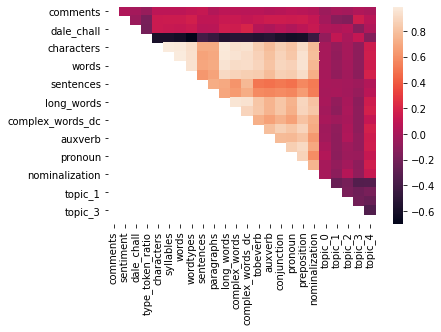

In [54]:
# Step 5: Correlation Heatmap
mask = np.tril(full_df.corr())
sns.heatmap(full_df.corr(), annot=False, mask=mask)
plt.show()

[6.61848196e-01 5.95543480e-02 5.35328270e-02 5.16559120e-02
 4.78754518e-02 3.49642078e-02 2.15538414e-02 1.69481229e-02
 1.38906609e-02 1.18677790e-02 8.08550420e-03 6.05620371e-03
 3.83563348e-03 3.47760811e-03 2.75189766e-03 1.11885247e-03
 6.09848010e-04 2.42089643e-04 1.31015985e-04]


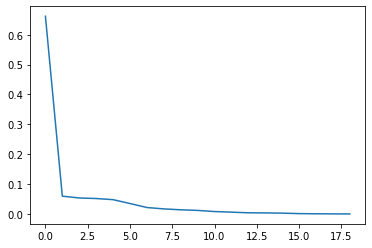

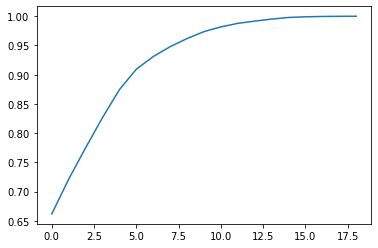

In [55]:
# Step 6: PCA
X = full_df[['comments', 'sentiment', 'dale_chall', 'type_token_ratio',
       'characters', 'syllables', 'words', 'wordtypes', 'sentences',
       'paragraphs', 'long_words', 'complex_words', 'complex_words_dc',
       'tobeverb', 'auxverb', 'conjunction', 'pronoun', 'preposition',
       'nominalization']]
# NOTE: there are some NAN in X. We will do nearest neighbor interpolation
# documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
X = X.interpolate(method="nearest")

# Create a train / test set
#sentiment = sentiment.reset_index(drop=True)
#sentiment_binary = (sentiment > 0) + 0
#sentiment_binary = np.ravel(sentiment_binary)
high = merged_df['high']
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    high,
                                                    test_size=0.2,
                                                    random_state=420)

# Fit PCA on X_train and X_test
# Scale
scaler = StandardScaler()
Z_train = scaler.fit_transform(X_train)
Z_test = scaler.fit_transform(X_test)

# Fit PCA to the Train set
pca = PCA(n_components=Z_train.shape[1], svd_solver='full')
pca.fit(Z_train)
# Transform
X_train_pca = pca.transform(Z_train)
X_test_pca = pca.transform(Z_test)

# determine variance explained
print(pca.explained_variance_ratio_)
plt.plot(range(Z_train.shape[1]), pca.explained_variance_ratio_)
plt.show()
plt.plot(range(Z_train.shape[1]), np.cumsum(pca.explained_variance_ratio_))
plt.show()
np.cumsum(pca.explained_variance_ratio_)
# 6 components explains 90% of the variance.
# so, let's take the 6 components and do PCA regression

# get the components
pca = PCA(n_components=6, svd_solver='full')
pca.fit(Z_train)
# Transform
X_train_pca = pca.transform(Z_train)
X_test_pca = pca.transform(Z_test)

In [56]:
# Step 7: Regression (Sentiment vs PC's)
# regression: sentiment vs PC's
npc = np.array(range(6)) + 1
pcnames = ['PC_' + str(i) for i in npc ]
X_train_pca = pd.DataFrame(X_train_pca, columns=pcnames)
X_test_pca = pd.DataFrame(X_test_pca, columns=pcnames)

Accuracy: 0.7546095350533004


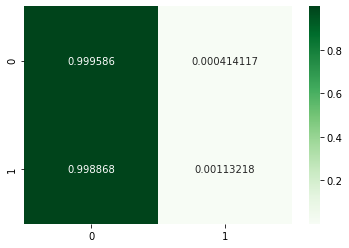

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     21733
           1       0.47      0.00      0.00      7066

    accuracy                           0.75     28799
   macro avg       0.61      0.50      0.43     28799
weighted avg       0.69      0.75      0.65     28799

Accuracy: 0.5018229799645821


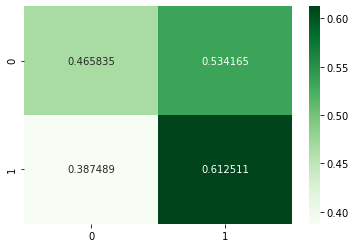

              precision    recall  f1-score   support

           0       0.79      0.47      0.59     21733
           1       0.27      0.61      0.38      7066

    accuracy                           0.50     28799
   macro avg       0.53      0.54      0.48     28799
weighted avg       0.66      0.50      0.53     28799

Accuracy: 0.7546442584811973


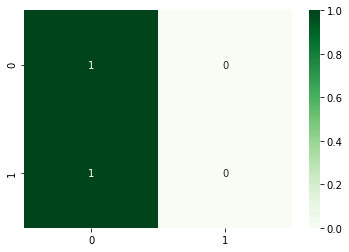

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     21733
           1       0.00      0.00      0.00      7066

    accuracy                           0.75     28799
   macro avg       0.38      0.50      0.43     28799
weighted avg       0.57      0.75      0.65     28799



In [65]:
# Step 8: Logistic Regression

#-------------------------------------
# Model 1: Vanilla Logistic Regression
#-------------------------------------
model1 = LogisticRegression(solver='liblinear',
                           penalty='l1',
                           random_state=20)#,
                           #class_weight='balanced')
# fit
model1.fit(X_train_pca, y_train)
# predict
model1_preds = model1.predict(X_test_pca)

# accuracy
acc = np.mean(model1_preds == y_test)
print('Accuracy: ' + str(acc))
pd.DataFrame(np.transpose(model1.coef_), index = X_train_pca.keys())

# Evaluate the model's performance
cm = confusion_matrix(y_test, model1_preds,  normalize = "true")
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')
plt.show()
np.mean(model1_preds)

print(classification_report(y_test, model1_preds))

#--------------------------------------------
# Model 2: Class Weighted Logistic Regression
#--------------------------------------------
model2 = LogisticRegression(solver='liblinear',
                           penalty='l1',
                           random_state=20,
                           class_weight={0: 1.33, 1: 4.027})#class_weight='balanced')
# fit
model2.fit(X_train_pca, y_train)
# predict
model2_preds = model2.predict(X_test_pca)

# accuracy
acc = np.mean(model2_preds == y_test)
print('Accuracy: ' + str(acc))
pd.DataFrame(np.transpose(model2.coef_), index = X_train_pca.keys())

# Evaluate the model's performance
cm = confusion_matrix(y_test, model2_preds,  normalize = "true")
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')
plt.show()
np.mean(model2_preds)

print(classification_report(y_test, model2_preds))


# now let's use just the topics
#-----------------------------------------------
# Model 3: Logistic Regression with Topic Scores
#-----------------------------------------------
df = full_df[['topic_0', 'topic_1', 'topic_2',
        'topic_3', 'topic_4']]

df = df.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(df,
                               high, test_size=0.2,random_state=420)

model3 = LogisticRegression(solver='liblinear',
                           penalty='l1',
                           random_state=420)

model3.fit(X_train, y_train)

model3_preds = model3.predict(X_test)

acc_train = np.mean(model3.predict(X_train) == y_train)
acc = np.mean(model3_preds == y_test) # Out[151]: for 5 components 0.7533 nice..
print('Accuracy: ' + str(acc))

pd.DataFrame(np.transpose(model3.coef_), index = X_train.keys())

# Evaluate the model's performance
cm = confusion_matrix(y_test, model3_preds,  normalize = "true")
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')
plt.show()
np.mean(model3_preds)

print(classification_report(y_test, model3_preds))

# AWFUL.

In [66]:
# Step 9: Use pipeline to improve models
X = full_df[['comments', 'sentiment', 'dale_chall', 'type_token_ratio',
       'characters', 'syllables', 'words', 'wordtypes', 'sentences',
       'paragraphs', 'long_words', 'complex_words', 'complex_words_dc',
       'tobeverb', 'auxverb', 'conjunction', 'pronoun', 'preposition',
       'nominalization', 'topic_0', 'topic_1', 'topic_2',
        'topic_3', 'topic_4']] # add back the topics.
# NOTE: there are some NAN in X. We will do nearest neighbor interpolation
# documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
X = X.interpolate(method="nearest")

high = merged_df['high']
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    high,
                                                    test_size=0.25,
                                                    random_state=410)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('PCA', PCA()),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

parameters = {'PCA__n_components': [1, 3, 5, 7],
              'classifier__C': [0.0001, 0.01, 0.1],# regularization
              'classifier__class_weight': ['balanced', {0: 1.33, 1:4.027}]}
# len(y_train)/y_train.value_counts()

grid_search = GridSearchCV(pipeline,
                           parameters,
                           n_jobs = -1,
                           cv = 10,
                           verbose = 1)
# Fitting 5 folds for each of 64 candidates, totalling 320 fits

grid_search.fit(X_train,
                y_train)

grid_search.best_score_ # 0.7499

grid_search.best_estimator_

pd.DataFrame(grid_search.cv_results_)

# assessing fit of best estimator
model4 = grid_search.best_estimator_

model4_preds = model4.predict(X_test)

acc_train = np.mean(model4.predict(X_train) == y_train)
acc = np.mean(model4_preds == y_test) # Out[151]: for 5 components 0.7533 nice..
print('Accuracy: ' + str(acc))

#pd.DataFrame(np.transpose(model4['classifier'].coef_),
#             index = X_train.keys())


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.3min finished


Accuracy: 0.5389743874659704


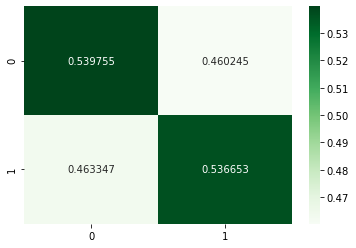

              precision    recall  f1-score   support

           0       0.78      0.54      0.64     26940
           1       0.28      0.54      0.37      9058

    accuracy                           0.54     35998
   macro avg       0.53      0.54      0.50     35998
weighted avg       0.65      0.54      0.57     35998



In [67]:
# Step 10: Evaluate model performance
cm = confusion_matrix(y_test, model4_preds,  normalize = "true")
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')
plt.show()
np.mean(model4_preds)

print(classification_report(y_test, model4_preds))

# Part 6: Miscellaneous

In [70]:
# Step 1: Import Modules
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df = pd.read_csv('df_final.csv')
# again we remove the null values of df
missing = (df["text"].isnull()) | ((df["text"] == '[deleted]')) | ((df["text"] == '[removed]'))
df = df.loc[~missing]

In [72]:
# how does the Dale-Chall score look?
feature_df = pd.read_csv('nlp_data/feature_df.csv', index_col = 0)

feature_df.keys()

Index(['dale_chall', 'characters_per_word', 'syll_per_word',
       'words_per_sentence', 'sentences_per_paragraph', 'type_token_ratio',
       'characters', 'syllables', 'words', 'wordtypes', 'sentences',
       'paragraphs', 'long_words', 'complex_words', 'complex_words_dc',
       'tobeverb', 'auxverb', 'conjunction', 'pronoun', 'preposition',
       'nominalization', 'id'],
      dtype='object')

In [74]:
feature_df['dale_chall'].describe()

count    177069.000000
mean         10.637621
std           2.908688
min           0.000000
25%           9.124023
50%          10.345010
75%          11.754195
max         188.432159
Name: dale_chall, dtype: float64

In [75]:
# example of min:
print(df[feature_df['dale_chall']==0]['text'].iloc[0])
print(df[feature_df['dale_chall']==0]['text'].iloc[10])
print(df[feature_df['dale_chall']==0]['text'].iloc[1])

Is there one? What is it? Otherwise do we need one? I think so, what should it be?
Thanks. 
thanks, sorry for being dumb


In [76]:
# This is HTML / CSS!
df[feature_df['dale_chall']==np.max(feature_df['dale_chall'])]['text'].iloc[0]

'Version:1.0 StartHTML:000000195 EndHTML:000029614 StartFragment:000029335 EndFragment:000029582 StartSelection:000029335 EndSelection:000029582 SourceURL:https://login.blockchain.com/en/   .\\_\\_react\\_component\\_tooltip{border-radius:3px;display:inline-block;font-size:13px;left:-999em;opacity:0;padding:8px 21px;position:fixed;pointer-events:none;transition:opacity 0.3s ease-out;top:-999em;visibility:hidden;z-index:999}.\\_\\_react\\_component\\_tooltip.allow\\_hover{pointer-events:auto}.\\_\\_react\\_component\\_tooltip:before,.\\_\\_react\\_component\\_tooltip:after{content:"";width:0;height:0;position:absolute}.\\_\\_react\\_component\\_tooltip.show{opacity:0.9;margin-top:0px;margin-left:0px;visibility:visible}.\\_\\_react\\_component\\_tooltip.type-dark{color:#fff;background-color:#222}.\\_\\_react\\_component\\_tooltip.type-dark.place-top:after{border-top-color:#222;border-top-style:solid;border-top-width:6px}.\\_\\_react\\_component\\_tooltip.type-dark.place-bottom:after{bord

In [78]:
# Above Mean Dale Chall
df[feature_df['dale_chall']>=np.mean(feature_df['dale_chall'])]['text'].iloc[0]


'With all the talk that increasing blocksize would reduce the full node count, why not make positive changes in the opposite direction?  Are any devs working on something that would *increase* the full node count?  And if not, why are they willing to hamstring the network to avoid a, say, 30% reduction in full node count?'